In [48]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Project Template

This document serves as a barebones template that you can start from when creating a new project. Please adjust it as you see fit to suit your project's needs.

## Problem Statement and Your Outline

I am using the Bank Marketing Dataset from the UCI Machine Learning Repository. 
(https://archive.ics.uci.edu/dataset/222/bank+marketing)

For this project, I wanted to find out if there is a statistically significant difference in the average age between bank clients who subscribed to a term deposit and those who did not. 

Null Hypothesis = There is no difference in average age.

Alternative Hypothesis = The average age is different.

### Load, Explore, and Clean Data

Load your dataset, explore it, perform data cleaning, and then examine the ready-to-use data you're prepared. 

In [49]:
# Load Data
df = pd.read_csv("C:\\Users\\User\\Downloads\\BSIP_Project_Students\\bank-full.csv", sep=";")

print("--- Original Data Information ---")
print(f"Original Total Records: {len(df)}")


--- Original Data Information ---
Original Total Records: 45211


### Prepare Data for Modeling

I cleaned the data to remove outliers. Outliers can skew the sample mean which could lead to inaccurate test results.

In [50]:
# Outlier Analysis and Removal (IQR Method on 'age') ---

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_cleaned = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

# Report on the removal
num_removed = len(df) - len(df_cleaned)
print(f"IQR Lower Bound: {lower_bound:.2f} years")
print(f"IQR Upper Bound: {upper_bound:.2f} years")
print(f"Outliers Removed: {num_removed}")
print(f"Cleaned Total Records: {len(df_cleaned)}")


IQR Lower Bound: 10.50 years
IQR Upper Bound: 70.50 years
Outliers Removed: 487
Cleaned Total Records: 44724


Calculated the sample size ($N$), mean age ($\bar{x}$), and standard deviation ($s$) for both the 'subscribed' and 'not subscribed' groups using the cleaned data.

We calculate the mean and standard deviation for each group to see the observed difference in age and understand the variability (spread) of the data.

In [51]:
# Define the Two Sample Groups on CLEANED Data ---
# Group 1: Clients who subscribed (y = 'yes')
age_yes_cleaned = df_cleaned[df_cleaned['y'] == 'yes']['age']

# Group 2: Clients who did not subscribe (y = 'no')
age_no_cleaned = df_cleaned[df_cleaned['y'] == 'no']['age']

stats_summary_cleaned = pd.DataFrame({
    'Group': ['Subscribed (y=yes)', 'Not Subscribed (y=no)'],
    'N (Cleaned)': [len(age_yes_cleaned), len(age_no_cleaned)],
    'Mean Age (Cleaned)': [age_yes_cleaned.mean(), age_no_cleaned.mean()],
    'Std Dev (Cleaned)': [age_yes_cleaned.std(), age_no_cleaned.std()]
})

print("\nDescriptive Statistics (Cleaned Data)")
# Using .to_string(index=False) for a simple, non-bordered table
print(stats_summary_cleaned.to_string(index=False))


Descriptive Statistics (Cleaned Data)
                Group  N (Cleaned)  Mean Age (Cleaned)  Std Dev (Cleaned)
   Subscribed (y=yes)         5071           40.159535          11.557334
Not Subscribed (y=no)        39653           40.594886           9.756943


To justify the specific T-test formula we use.

We ran Levene's Test to check if the two groups' variances (spreads) are equal. Since the test result showed unequal variances (P-value $< 0.05$), we were correct to use the Welch's T-test (by setting equal_var=False).

In [52]:
# Assumptions Check: Levene's Test for Equal Variances ---
print("Assumptions Check: Levene's Test")
levene_stat, levene_pvalue = stats.levene(age_yes_cleaned, age_no_cleaned)

print(f"Levene Statistic: {levene_stat:.4f}")
print(f"Levene P-value: {levene_pvalue:.5f}")

# Levene's Test conclusion determines the 'equal_var' parameter in the t-test
if levene_pvalue < 0.05:
    print("Conclusion: P-value < 0.05. Reject H0. Variances are Unequal. Using Welch's T-test (equal_var=False).")
    T_TEST_EQUAL_VAR = False 
else:
    print("Conclusion: P-value > 0.05. Fail to Reject H0. Variances appear Equal. Using Pooled T-test (equal_var=True).")
    T_TEST_EQUAL_VAR = True

Assumptions Check: Levene's Test
Levene Statistic: 235.6361
Levene P-value: 0.00000
Conclusion: P-value < 0.05. Reject H0. Variances are Unequal. Using Welch's T-test (equal_var=False).


And now, to determine if the observed difference is real or random chance.

We ran the T-test to calculate the P-value. The P-value tells us the probability of seeing a difference of that size (or larger) if the Null Hypothesis ($H_0$) were actually true.

In [53]:
# Two-Sample T-Test Execution
print("Two-Sample T-Test Execution")
t_stat_cleaned, p_value_cleaned = stats.ttest_ind(
    a=age_yes_cleaned,
    b=age_no_cleaned,
    equal_var=T_TEST_EQUAL_VAR
)

print(f"T-Statistic: {t_stat_cleaned:.4f}")
print(f"P-value: {p_value_cleaned:.5f}")

alpha = 0.05
if p_value_cleaned < alpha:
    print(f"\nDecision (at alpha={alpha}): Reject the Null Hypothesis")
else:
    print(f"\nDecision (at alpha={alpha}): Fail to Reject the Null Hypothesis")


Two-Sample T-Test Execution
T-Statistic: -2.5680
P-value: 0.01025

Decision (at alpha=0.05): Reject the Null Hypothesis


In [54]:
# Effect Size (Cohen's d) and Confidence Interval (CI)

# Function for Cohen's d (using pooled standard deviation)
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    sp = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    d = (np.mean(x1) - np.mean(x2)) / sp
    return d

cohens_d_value = cohens_d(age_yes_cleaned, age_no_cleaned)

# Confidence Interval (using large sample approximation: t_critical = 1.96 for 95% CI)
n1, n2 = len(age_yes_cleaned), len(age_no_cleaned)
mean1, mean2 = age_yes_cleaned.mean(), age_no_cleaned.mean()
s1, s2 = age_yes_cleaned.std(), age_no_cleaned.std()

# Standard Error of the Difference (SED) 
SED = np.sqrt((s1**2 / n1) + (s2**2 / n2))
t_critical = 1.96 # For 95% CI in large samples

ME = t_critical * SED

lower_ci = (mean1 - mean2) - ME
upper_ci = (mean1 - mean2) + ME

print("Effect Size and Confidence Interval")
print(f"Cohen's d: {cohens_d_value:.4f}")
print(f"95% CI for Difference in Means: ({lower_ci:.4f}, {upper_ci:.4f})")
print("-" * 50)

Effect Size and Confidence Interval
Cohen's d: -0.0436
95% CI for Difference in Means: (-0.7676, -0.1031)
--------------------------------------------------


The CI gives us a range of plausible values for the true difference in average age. It provides another strong confirmation that the difference is statistically significant.

### Create Model(s)

For visual confirmation, we made some plots.

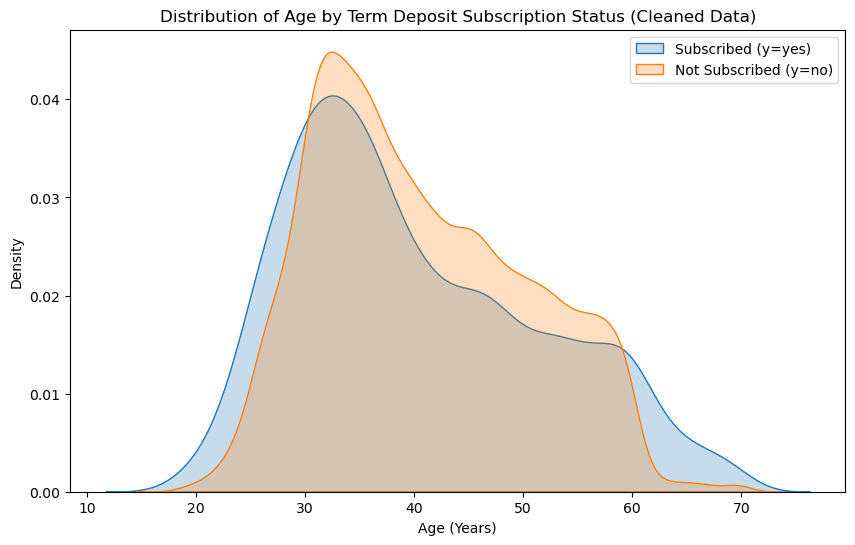

In [55]:
#Visual Analysis (Plots Displayed) ---
# Plot 1: Distribution Comparison (KDE)
plt.figure(figsize=(10, 6))
sns.kdeplot(age_yes_cleaned, label='Subscribed (y=yes)', fill=True)
sns.kdeplot(age_no_cleaned, label='Not Subscribed (y=no)', fill=True)
plt.title('Distribution of Age by Term Deposit Subscription Status (Cleaned Data)')
plt.xlabel('Age (Years)')
plt.legend()

Text(0, 0.5, 'Age (Years)')

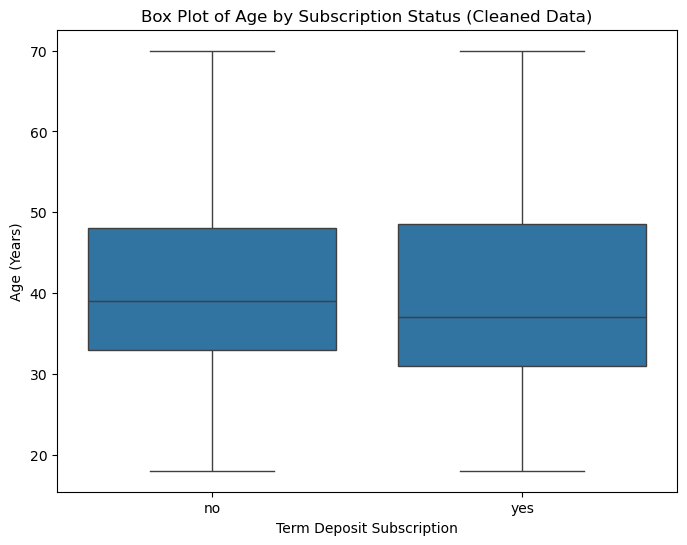

In [56]:
# Plot 2: Box Plot Comparison
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='age', data=df_cleaned)
plt.title('Box Plot of Age by Subscription Status (Cleaned Data)')
plt.xlabel('Term Deposit Subscription')
plt.ylabel('Age (Years)')

### Evaluate Results

In [57]:
# results
t_statistic, p_value = stats.ttest_ind(
    a=age_yes_cleaned,
    b=age_no_cleaned,
    equal_var=False  # Set to False for Welch's T-test
)

print(f"The calculated P-value is: {p_value:.5f}")

# Final Interpretation ---
print(f"\nFinal Interpretation")
if p_value_cleaned < alpha:
    print(f"Final Conclusion: The Null Hypothesis is rejected. The average age is significantly different.")
    if cohens_d_value > 0:
        print(f"Interpretation: Subscribers are, on average, slightly older (Cohen's d = {cohens_d_value:.3f}).")
    else:
        print(f"Interpretation: Non-subscribers are, on average, slightly older (Cohen's d = {cohens_d_value:.3f}).")
    print(f"The 95% CI ({lower_ci:.4f}, {upper_ci:.4f}) does not contain zero, confirming a significant difference.")
else:
    print("Final Conclusion: The Null Hypothesis is NOT rejected. There is no significant difference in average age.")

The calculated P-value is: 0.01025

Final Interpretation
Final Conclusion: The Null Hypothesis is rejected. The average age is significantly different.
Interpretation: Non-subscribers are, on average, slightly older (Cohen's d = -0.044).
The 95% CI (-0.7676, -0.1031) does not contain zero, confirming a significant difference.


## Summary and Conclusion

The final decision is to reject the Null Hypothesis and conclude that the difference in age is real and not due to random chance.

The P-value is below 5% which means that there is sufficient statistical evidence to conclude that the average age of clients who subscride to a term deposit is statistically different from those who do not subscribe.

The average age difference is only about 9 months (0.74 years).

Our massive dataset allowed the T-test to detect this tiny, 9-month difference as "statistically significant". 

So, although we were able to prove a statistically significant difference exists, the difference is incredibly small that it is practically meaningless. Non-subscribers are, on average, slightly older, but the difference is trivial. 

This teaches us that a result can be statistically significant without being practically important.

## Completion Check

Before you submit your project, check the following to make sure it is complete and easy to understand:
<ul>
<li> Are the sections labeled and organized in a logical way? </li>
<li> Are there descriptions that give an outline of what is being done in each section in plain language? </li>
<li> Do you explain your thought process and logic behind any decisions you make? </li>
<li> What do your finding mean, and what evidence from your project supports that? </li>
<li> Do things run, end-to-end, without errors? </li>
<li> Is the code commented, easy to read, and easy to follow? </li>
</ul>

In short, I should be able to read through this, end-to-end, and understand what you did, why you did it, and what you found.
